Imports

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw

Model and Custom Augmentation

In [2]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # First block
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.2)

        # Second block
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.2)

        # Third block
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.2)

        # Fourth block
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout4 = nn.Dropout(0.2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)  # After 4 pooling layers, size will be 2x2
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout_fc1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 100)  # Output layer (100 classes)

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Fourth block
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        # Flatten and fully connected layers
        x = self.flatten(x)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        x = self.fc2(x)  # Final output layer with softmax applied outside (for multi-class classification)

        return x

    def save(self, save_path: str):
        file = os.path.join(save_path, "log.pkl")
        with open(file, "wb") as f:
            pickle.dump(self.metrics, f)

# Create the model
model = CNNModel()

# Print the model architecture
print(model)

CNNModel(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(

In [3]:
def add_black_squares(image, num_squares=7, square_size_range=(3, 6)):
    """
    Adds black squares to the image to occlude parts of it.
    """
    width, height = image.size
    draw = ImageDraw.Draw(image)

    for _ in range(num_squares):
        # Randomly determine the size of the square
        square_size = random.randint(square_size_range[0], square_size_range[1])

        # Randomly determine the top-left corner of the square
        top_left_x = random.randint(0, width - square_size)
        top_left_y = random.randint(0, height - square_size)

        # Define the bottom-right corner of the square
        bottom_right_x = top_left_x + square_size
        bottom_right_y = top_left_y + square_size

        # Draw a black square
        draw.rectangle([top_left_x, top_left_y, bottom_right_x, bottom_right_y], fill="black")

    return image

# Custom transformation to add black squares
class AddBlackSquaresTransform:
    def __init__(self, num_squares=7, square_size_range=(3, 6)):
        self.num_squares = num_squares
        self.square_size_range = square_size_range

    def __call__(self, image):
        return add_black_squares(image, self.num_squares, self.square_size_range)

First run with only transform is normalization

In [4]:
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
])

In [5]:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=basic_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=basic_transform)

100%|██████████| 169M/169M [00:03<00:00, 49.2MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Epoch [1/15], Train Loss: 3.7696, Train Accuracy: 12.06%, Validation Loss: 3.1805, Validation Accuracy: 21.09%
Epoch [2/15], Train Loss: 2.8027, Train Accuracy: 28.10%, Validation Loss: 2.5275, Validation Accuracy: 34.12%
Epoch [3/15], Train Loss: 2.2352, Train Accuracy: 39.60%, Validation Loss: 2.1333, Validation Accuracy: 42.76%
Epoch [4/15], Train Loss: 1.8693, Train Accuracy: 48.32%, Validation Loss: 2.0179, Validation Accuracy: 45.41%
Epoch [5/15], Train Loss: 1.6087, Train Accuracy: 54.51%, Validation Loss: 1.6568, Validation Accuracy: 54.12%
Epoch [6/15], Train Loss: 1.3631, Train Accuracy: 60.41%, Validation Loss: 1.6771, Validation Accuracy: 54.00%
Epoch [7/15], Train Loss: 1.1597, Train Accuracy: 65.78%, Validation Loss: 1.6131, Validation Accuracy: 56.52%
Epoch [8/15], Train Loss: 0.9610, Train Accuracy: 71.05%, Validation Loss: 1.5199, Validation Accuracy: 59.09%
Epoch [9/15], Train Loss: 0.7811, Train Accuracy: 75.88%, Validation Loss: 1.5754, Validation Accuracy: 59.38%
E

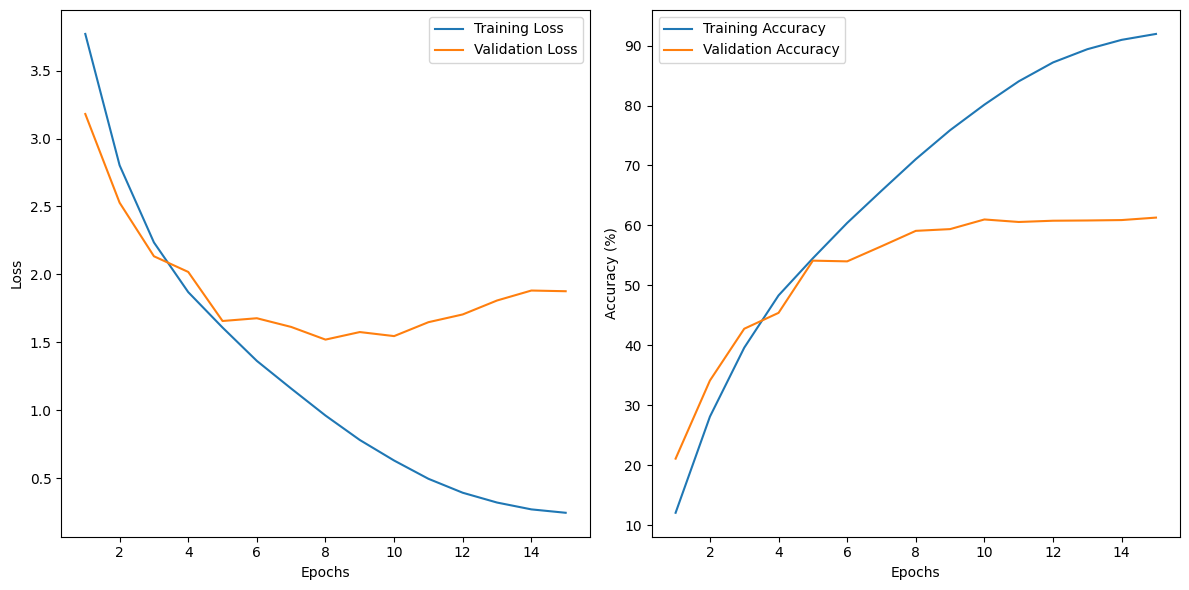

AttributeError: 'CNNModel' object has no attribute 'metrics'

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, criterion, and optimizer setup
model = CNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store the loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct / total) * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = (val_correct / val_total) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot the training and validation loss and accuracy
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Save the trained model
#model.save("/content/Models/Basic") # Save model to the specified directory
torch.save(model.state_dict(), '/content/Models/Basic/cnn_model.pth')

Apply custom augmentation and train

In [12]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
])

train_transform = transforms.Compose([
    AddBlackSquaresTransform(num_squares=7, square_size_range=(3, 6)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=False, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=False, transform=test_transform)


Epoch [1/15], Train Loss: 3.9648, Train Accuracy: 9.15%, Validation Loss: 3.5819, Validation Accuracy: 14.45%
Epoch [2/15], Train Loss: 3.2425, Train Accuracy: 20.56%, Validation Loss: 2.9362, Validation Accuracy: 26.00%
Epoch [3/15], Train Loss: 2.7561, Train Accuracy: 29.41%, Validation Loss: 2.5187, Validation Accuracy: 35.25%
Epoch [4/15], Train Loss: 2.3787, Train Accuracy: 37.04%, Validation Loss: 2.3767, Validation Accuracy: 37.80%
Epoch [5/15], Train Loss: 2.0982, Train Accuracy: 43.12%, Validation Loss: 1.9948, Validation Accuracy: 46.74%
Epoch [6/15], Train Loss: 1.8769, Train Accuracy: 48.34%, Validation Loss: 1.8798, Validation Accuracy: 49.50%
Epoch [7/15], Train Loss: 1.6916, Train Accuracy: 52.61%, Validation Loss: 1.8420, Validation Accuracy: 50.50%
Epoch [8/15], Train Loss: 1.5272, Train Accuracy: 56.63%, Validation Loss: 1.6376, Validation Accuracy: 54.97%
Epoch [9/15], Train Loss: 1.3622, Train Accuracy: 60.87%, Validation Loss: 1.6608, Validation Accuracy: 54.57%
Ep

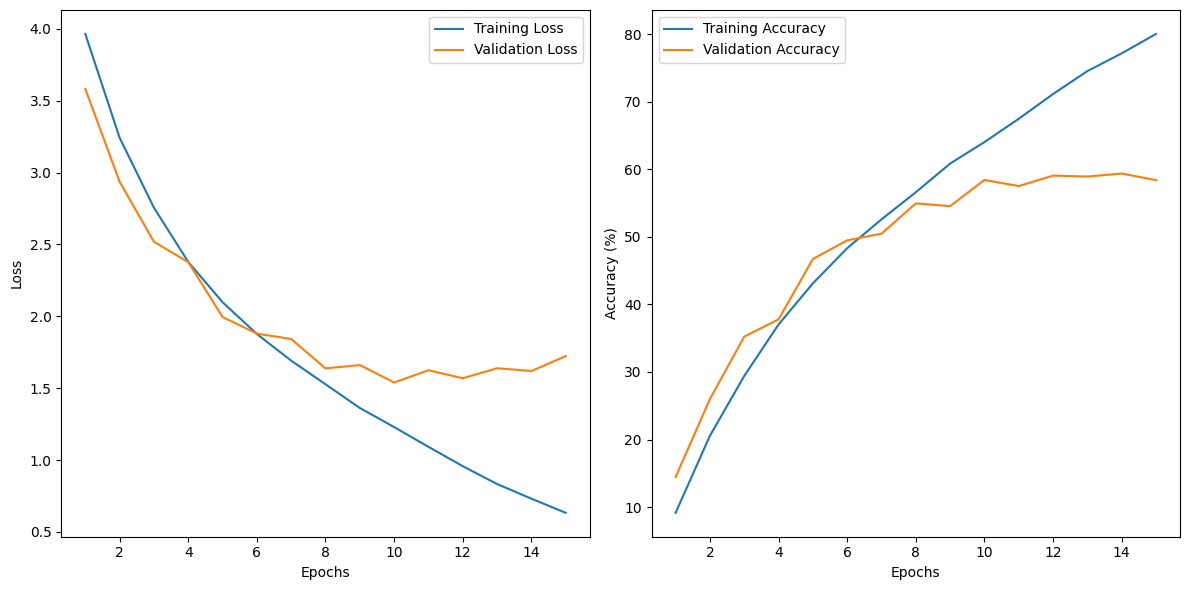

In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, criterion, and optimizer setup
model = CNNModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store the loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct / total) * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = (val_correct / val_total) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot the training and validation loss and accuracy
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Save the trained model
#model.save("/content/Models/Custom") # Save model to the specified directory
torch.save(model.state_dict(), '/content/Models/Custom/cnn_model.pth')

Apply full transform and train

In [14]:
transform_train = transforms.Compose([
    AddBlackSquaresTransform(num_squares=7, square_size_range=(3, 6)),    #Custom Random occlusion transform
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomRotation(15),            # Random rotation by up to 15 degrees
    transforms.RandomCrop(32, padding=4),    # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random color jitter
    transforms.ToTensor(),                    # Convert image to Tensor
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))  # Normalize to [0, 1] range
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=False, transform=test_transform)

Epoch [1/15], Train Loss: 4.2022, Train Accuracy: 5.91%, Validation Loss: 3.9543, Validation Accuracy: 9.85%
Epoch [2/15], Train Loss: 3.6805, Train Accuracy: 12.96%, Validation Loss: 3.3850, Validation Accuracy: 18.54%
Epoch [3/15], Train Loss: 3.3271, Train Accuracy: 19.01%, Validation Loss: 2.9789, Validation Accuracy: 26.09%
Epoch [4/15], Train Loss: 3.0292, Train Accuracy: 24.27%, Validation Loss: 2.6154, Validation Accuracy: 32.42%
Epoch [5/15], Train Loss: 2.7722, Train Accuracy: 29.37%, Validation Loss: 2.3664, Validation Accuracy: 37.43%
Epoch [6/15], Train Loss: 2.5678, Train Accuracy: 33.54%, Validation Loss: 2.2761, Validation Accuracy: 40.60%
Epoch [7/15], Train Loss: 2.3899, Train Accuracy: 37.25%, Validation Loss: 2.0211, Validation Accuracy: 45.56%
Epoch [8/15], Train Loss: 2.2412, Train Accuracy: 40.67%, Validation Loss: 2.0638, Validation Accuracy: 44.42%
Epoch [9/15], Train Loss: 2.1336, Train Accuracy: 42.85%, Validation Loss: 1.7953, Validation Accuracy: 50.44%
Epo

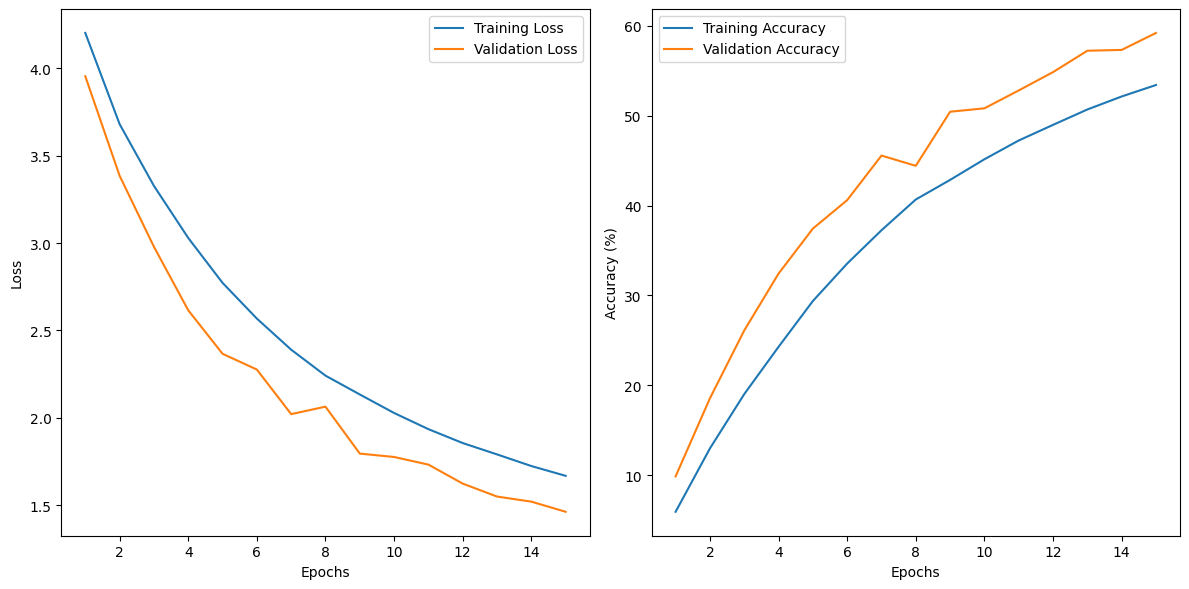

In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, criterion, and optimizer setup
model = CNNModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store the loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct / total) * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = (val_correct / val_total) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot the training and validation loss and accuracy
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Save the trained model
#model.save("/content/Models/Full") # Save model to the specified directory
torch.save(model.state_dict(), '/content/Models/Full/cnn_model.pth')

Epoch [1/50], Train Loss: 4.2026, Train Accuracy: 5.99%, Validation Loss: 3.6969, Validation Accuracy: 11.80%
Epoch [2/50], Train Loss: 3.6532, Train Accuracy: 13.31%, Validation Loss: 3.3055, Validation Accuracy: 18.92%
Epoch [3/50], Train Loss: 3.3055, Train Accuracy: 19.24%, Validation Loss: 2.9038, Validation Accuracy: 26.94%
Epoch [4/50], Train Loss: 3.0266, Train Accuracy: 24.57%, Validation Loss: 2.6967, Validation Accuracy: 30.81%
Epoch [5/50], Train Loss: 2.7852, Train Accuracy: 29.13%, Validation Loss: 2.4814, Validation Accuracy: 35.24%
Epoch [6/50], Train Loss: 2.5661, Train Accuracy: 33.12%, Validation Loss: 2.2479, Validation Accuracy: 40.78%
Epoch [7/50], Train Loss: 2.3994, Train Accuracy: 36.77%, Validation Loss: 2.0457, Validation Accuracy: 44.58%
Epoch [8/50], Train Loss: 2.2560, Train Accuracy: 39.87%, Validation Loss: 1.9818, Validation Accuracy: 46.33%
Epoch [9/50], Train Loss: 2.1313, Train Accuracy: 42.85%, Validation Loss: 1.8416, Validation Accuracy: 49.71%
Ep

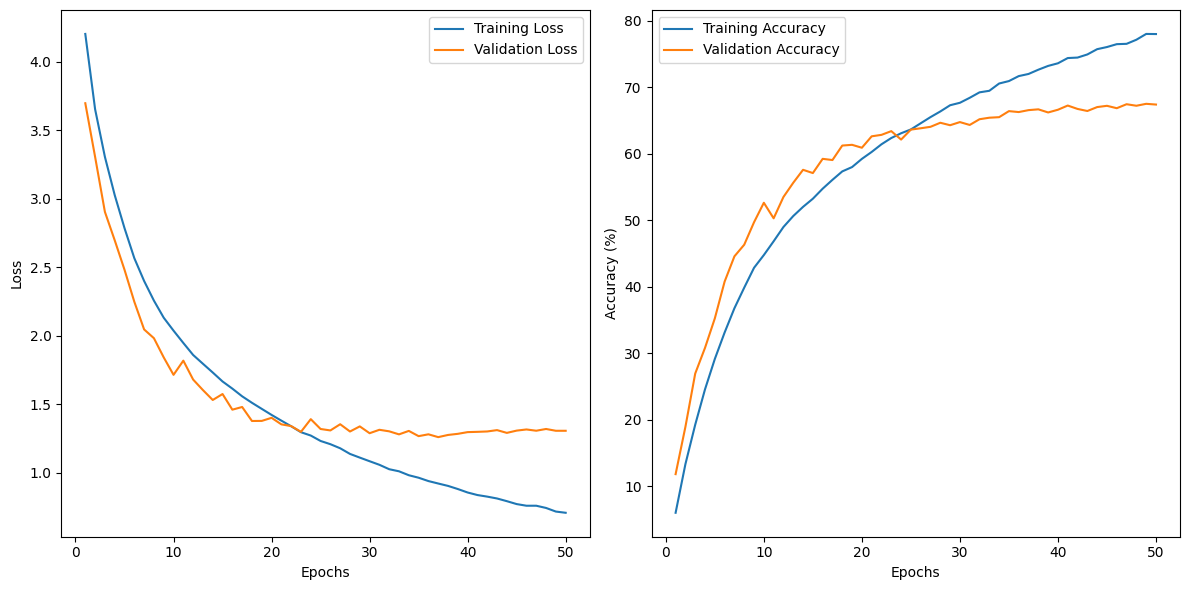

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, criterion, and optimizer setup
model = CNNModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store the loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct / total) * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = (val_correct / val_total) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot the training and validation loss and accuracy
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Save the trained model
#model.save("/content/Models/Full") # Save model to the specified directory
torch.save(model.state_dict(), '/content/Models/Full/cnn_model_extra_train.pth')